# Imports

In [ ]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

# Task 1 : Extrinsic Estimation (20 Points)

You are given 5 images in the `data/Images` folder, and their corresponding 2d-3d correspondences in `data/Correspondences`. Use this information with the Ceres Solver to optimize for the extrinsic of each image using Reprojection Loss.

### Camera Intrinsics:
`fx` = `fy` = 721.5
 
`cx` and `cy` : $\frac{width}{2}$ and $\frac{height}{2}$

### Format for Correspondences:
`px py X Y Z i`
where: `p_x` and `p_y` are the 2d image coordinates, and `X`, `Y` and `Z` are the coordinates of the 3d correspondence for the 2d coordinate, and `i` is the 3d point's index in the pointcloud (you can ignore i, just use the rest of the information as is).


### Resources:
http://ceres-solver.org/nnls_solving.html <br>
http://ceres-solver.org/nnls_modeling.html <br>
http://ceres-solver.org/nnls_tutorial.html <br>

In [2]:
os.system('bash compile.sh')

-- Found AMD headers in: /usr/include/suitesparse
-- Found AMD library: /usr/lib/libamd.so
-- Found CAMD headers in: /usr/include/suitesparse
-- Found CAMD library: /usr/lib/libcamd.so
-- Found CCOLAMD headers in: /usr/include/suitesparse
-- Found CCOLAMD library: /usr/lib/libccolamd.so
-- Found CHOLMOD headers in: /usr/include/suitesparse
-- Found CHOLMOD library: /usr/lib/libcholmod.so
-- Found COLAMD headers in: /usr/include/suitesparse
-- Found COLAMD library: /usr/lib/libcolamd.so
-- Found SPQR headers in: /usr/include/suitesparse
-- Found SPQR library: /usr/lib/libspqr.so
-- Found Config headers in: /usr/include/suitesparse
-- Found Config library: /usr/lib/libsuitesparseconfig.so
-- Found Intel Thread Building Blocks (TBB) library (2021.13 / ) include location: . Assuming SuiteSparseQR was compiled with TBB.
-- Adding librt to SuiteSparse_config libraries (required on Linux & Unix [not OSX] if SuiteSparse is compiled with timing).
-- Could NOT find METIS (missing: METIS_INCLUDE_

0

# Task 2 : Two-View Geometry Task (35 Points)

### Note:  Use images in folder data_Q2  and the file `data_Q2/intrinsics.txt` has camera intrinsics 
### Don't use Opencv functions unless explicitly mentioned. 

<img src="data_Q2/first_img.jpg" alt="image 1" width="400"/>
<img src="data_Q2/second_img.jpg" alt="image 2" width="400"/>

### Bonus : All theory questions are part of bonus unless mentioned explicitly. (15 Points)

### 1. Feature Extraction and Matching
   **Implement a function to detect and match feature points between two images using OpenCV's SIFT or ORB.**  
   Visualize the matched points and filter outliers using RANSAC. 
   
   Theory : How do you ensure that the matches are accurate, and what thresholding techniques do you apply?

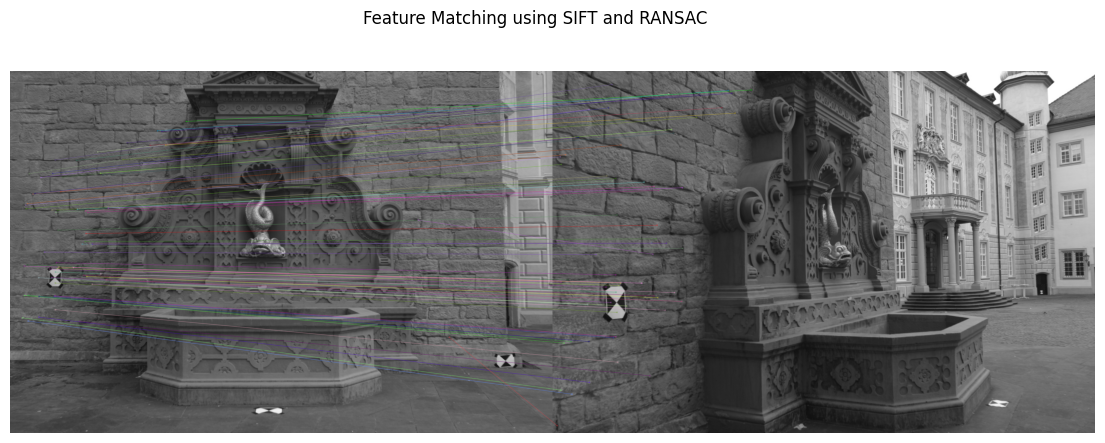

In [ ]:
def detect_and_match_features(img1, img2):
    """ Detect and match feature points between two images using SIFT. """

    # Detect keypoints and descriptors
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Match features
    flann = cv2.FlannBasedMatcher({'algorithm': 1, 'trees': 5}, {'checks': 50})
    matches = flann.knnMatch(des1, des2, k=2)

    # Extract points from matches
    points1 = []
    points2 = []
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.8 * n.distance:
            points2.append(kp2[m.trainIdx].pt)
            points1.append(kp1[m.queryIdx].pt)
    points1 = np.int32(points1)
    points2 = np.int32(points2)

    # Filter out outliers
    _, mask = cv2.findFundamentalMat(points1, points2, cv2.RANSAC)
    points1 = points1[mask.ravel() == 1]
    points2 = points2[mask.ravel() == 1]

    # Draw matches
    inlier_matches = []
    for pt1, pt2 in zip(points1, points2):
        kp1_inlier = cv2.KeyPoint(x=int(pt1[0]), y=int(pt1[1]), size=1)
        kp2_inlier = cv2.KeyPoint(x=int(pt2[0]), y=int(pt2[1]), size=1)
        match = cv2.DMatch(_queryIdx=len(inlier_matches), _trainIdx=len(inlier_matches), _distance=0)
        inlier_matches.append(match)
    matched_img = cv2.drawMatches(img1, [cv2.KeyPoint(int(x), int(y), 1) for x, y in points1],
                                  img2, [cv2.KeyPoint(int(x), int(y), 1) for x, y in points2],
                                  inlier_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return matched_img, points1, points2

img1 = cv2.imread('data_Q2/first_img.jpg', 0)
img2 = cv2.imread('data_Q2/second_img.jpg', 0)

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

matched_img, points1, points2 = detect_and_match_features(img1, img2)

plt.figure(figsize=(14, 5))
plt.suptitle('Feature Matching using SIFT and RANSAC')
plt.imshow(matched_img)
plt.axis('off')
plt.tight_layout()
plt.show()

**Answer:**

- Tests like Lowe's ratio test, that compare the distance to the nearest neighbor to the next nearest neighbor, can be applied to ensure that the matches are accurate.

- Techniques like RANSAC filter out the inliers and consequently threshold subset of points based on the noise levels.

### 2. Fundamental Matrix Estimation
   **Write a function `compute_fundamental_matrix` to estimate the fundamental matrix using the 8-point algorithm.**  
   Normalize the points before estimating and check the rank of the matrix. Explain why normalization is essential in this context.
   
   Extend this to include the 7-point algorithm, and compare the accuracy of the two methods on your matched points.

In [158]:
def normalize_points(points):
    mean = np.mean(points, axis=0)
    std = np.std(points)
    T = np.array([[1/std, 0, -mean[0]/std],
                    [0, 1/std, -mean[1]/std],
                    [0, 0, 1]])
    points_hom = np.hstack((points, np.ones((points.shape[0], 1))))
    normalized_points = (T @ points_hom.T).T
    return normalized_points, T

def compute_fundamental_matrix(pts1, pts2, method):
    """ Estimates the fundamental matrix for a set of matched points. """

    if method == '8-point':
        pts1_norm, T1 = normalize_points(pts1)
        pts2_norm, T2 = normalize_points(pts2)

        # Construct matrix A
        A = np.array([
            pts2_norm[:, 0] * pts1_norm[:, 0],  # x'x
            pts2_norm[:, 0] * pts1_norm[:, 1],  # x'y
            pts2_norm[:, 0],                    # x'
            pts2_norm[:, 1] * pts1_norm[:, 0],  # y'x
            pts2_norm[:, 1] * pts1_norm[:, 1],  # y'y
            pts2_norm[:, 1],                    # y'
            pts1_norm[:, 0],                    # x
            pts1_norm[:, 1],                    # y
            np.ones(pts1_norm.shape[0])         # 1
        ]).T

        # Solve Af = 0 using SVD
        _, _, V = np.linalg.svd(A)
        F = V[-1].reshape(3, 3)

        # Enforce rank-2 constraint on F
        U, S, V = np.linalg.svd(F)
        S[2] = 0
        F = U @ np.diag(S) @ V

        # Denormalize F
        F = T2.T @ F @ T1

        return F

    if method == '7-point':
        pts1_norm, T1 = normalize_points(pts1)
        pts2_norm, T2 = normalize_points(pts2)

        # Construct matrix A
        A = np.array([
            pts2_norm[:, 0] * pts1_norm[:, 0],
            pts2_norm[:, 0] * pts1_norm[:, 1],
            pts2_norm[:, 0],
            pts2_norm[:, 1] * pts1_norm[:, 0],
            pts2_norm[:, 1] * pts1_norm[:, 1],
            pts2_norm[:, 1],
            pts1_norm[:, 0],
            pts1_norm[:, 1],
            np.ones(pts1_norm.shape[0])
        ]).T

        # Solve Af = 0 using SVD
        _, _, V = np.linalg.svd(A)
        F1 = V[-1].reshape(3, 3)
        F2 = V[-2].reshape(3, 3)

        # Solve for the scalar values that make det(alpha * F1 + (1 - alpha) * F2) = 0
        def determinant_func(alpha):
            F = alpha * F1 + (1 - alpha) * F2
            return np.linalg.det(F)

        # Find the roots of the cubic equation
        a0 = determinant_func(0)
        a1 = 2 * (determinant_func(1) - determinant_func(0.5)) - a0
        a2 = determinant_func(0.5) - a0
        a3 = a0
        coefficients = [a3, a2, a1, a0]
        alphas = np.roots(coefficients)

        # Compute the possible F matrices
        F_list = []
        for alpha in alphas:
            F = alpha * F1 + (1 - alpha) * F2
            # Enforce rank-2 constraint on F
            U, S, V = np.linalg.svd(F)
            S[2] = 0
            F = U @ np.diag(S) @ V
            F_list.append(T2.T @ F @ T1)

        return F_list

    raise ValueError(f'Got unexpected value for method {method}')

F = compute_fundamental_matrix(points1, points2, '8-point')
print(F)

[[-6.17530058e-08 -4.59939256e-07  4.01624916e-04]
 [-2.27735777e-07  1.35340276e-08 -1.00042350e-03]
 [ 4.40856519e-04  2.09161343e-03 -1.13723234e+00]]


**Answer:**

- Normalization can improve stability, especially when coordinates vary significantly. It ensures the mean is at the origin and the average distance is normalized across axes.

- The 8-point algorithm is more sensitive to noise, while the 7-point algorithm can be more robust in certain scenarios.

### 3. Epipolar Lines Visualization
   **Write a function to plot epipolar lines on both images given the estimated fundamental matrix.**  
   For each matched feature in the first image, compute and draw the corresponding epipolar line in the second image.

   Theory (not part of bonus) : What methods can you use to verify that the epipolar lines are accurate?

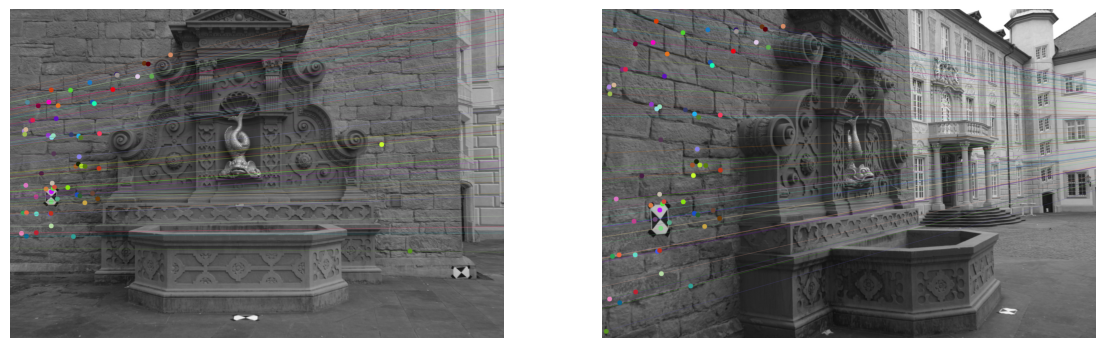

In [ ]:
def draw_lines(img1, img2, lines, pts1, pts2):
    """ Draw the epilines on img1 for the points in img2. """

    r, c, _ = img1.shape
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, (int(pt1[0]), int(pt1[1])), 15, color, -1)
        img2 = cv2.circle(img2, (int(pt2[0]), int(pt2[1])), 15, color, -1)
    return img1, img2

def compute_epilines(pts, F):
    """ Computes the corresponding epilines in the other image. """

    pts_homogeneous = np.hstack((pts, np.ones((pts.shape[0], 1))))
    lines = np.dot(F, pts_homogeneous.T).T
    lines /= np.sqrt(lines[:, 0]**2 + lines[:, 1]**2).reshape(-1, 1)
    return lines

def draw_epipolar_lines(img1, img2, points1, points2, F):
    lines1 = compute_epilines(points2, F.T)
    lines2 = compute_epilines(points1, F)

    img3, img4 = draw_lines(img2, img1, lines2, points2, points1)
    img5, img6 = draw_lines(img1, img2, lines1, points1, points2)

    return img4, img6

epipolar_lines = draw_epipolar_lines(img1, img2, points1, points2, F)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Epipolar Lines')
axs[0].imshow(epipolar_lines[0])
axs[0].axis('off')
axs[1].imshow(epipolar_lines[1])
axs[1].axis('off')
plt.tight_layout()
plt.show()

**Answer:**

- To ensure correction, we can check if epipolar lines for points in the first image intersect the corresponding points in the second image.

### 4. Epipole Computation
   **Implement a function to calculate the epipoles from the fundamental matrix.**  
   Verify their correctness by showing that epipolar lines intersect at these points.

   Theory : What happens to the epipole location if the fundamental matrix is rank-deficient, and how can you simulate this scenario?

In [165]:
def compute_epipoles(F):
    U, S, Vt = np.linalg.svd(F)
    e1 = Vt[-1] / Vt[-1][-1]  # Epipole in image 1 (right null space)
    e2 = U[:, -1] / U[:, -1][-1]  # Epipole in image 2 (left null space)
    return e1, e2

compute_epipoles(F)

(array([-4.30665614e+03,  1.45143923e+03,  1.00000000e+00]),
 array([4.56809992e+03, 6.97135164e+02, 1.00000000e+00]))

**Answer:**

- If the fundamental matrix is not full rank, the epipole computation is affected. Simulating a rank-deficient scenario involves setting one of the singular values of F to zero, which alters the geometry.

### 5. Camera Pose from Fundamental Matrix
   **Write a function `camera_pose_from_fundamental` to compute the four possible camera poses (rotation `R` and translation `t`) from the fundamental matrix and intrinsic matrix `K`.**

   Theory (not part of bonus) : Explain why there are four possible solutions and how to verify which is the correct one.

In [166]:
def camera_pose_from_fundamental(F, K):
    # Compute the Essential matrix: E = K.T * F * K
    E = K.T @ F @ K

    # Perform Singular Value Decomposition of E
    U, S, Vt = np.linalg.svd(E)

    # Ensure the determinant is positive for a valid rotation
    if np.linalg.det(U) < 0: U *= -1
    if np.linalg.det(Vt) < 0: Vt *= -1

    # Possible rotation matrices
    W = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 1]])
    R1 = U @ W @ Vt
    R2 = U @ W.T @ Vt

    # Ensure rotations are valid (det(R) should be +1)
    if np.linalg.det(R1) < 0: R1 *= -1
    if np.linalg.det(R2) < 0: R2 *= -1

    # Possible translations (t is the last column of U)
    t = U[:, 2]

    # Four possible poses
    poses = [
        (R1,  t),
        (R1, -t),
        (R2,  t),
        (R2, -t)
    ]
    return poses

K = np.loadtxt('data_Q2/intrinsics.txt')
poses = camera_pose_from_fundamental(F, K)

**Answer:**

- The decomposition of the essential matrix yields two possible rotation matrices and two possible translations, leading to four (R, t) combinations. This arises because the ambiguity in the sign of t and the rotation symmetry around the principal axis.

- The correct pose is the one where the triangulated 3D points lie in front of both cameras, as determined using the cheirality condition.

### 6. Triangulation of 3D Points
   **Implement linear triangulation in a function `linear_triangulation` that takes the projection matrices and point correspondences to compute 3D points.**

   Visualize the triangulated points in 3D and describe how the accuracy of 3D points depends on the quality of the fundamental matrix and camera pose.

In [167]:
def linear_triangulation(P1, P2, points1, points2):
    points_3d = []
    for p1, p2 in zip(points1, points2):
        A = [
            (p1[0] * P1[2] - P1[0]),
            (p1[1] * P1[2] - P1[1]),
            (p2[0] * P2[2] - P2[0]),
            (p2[1] * P2[2] - P2[1])
        ]
        A = np.array(A)
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]
        X = X / X[3]
        points_3d.append(X[:3])
    return np.array(points_3d)

### 7. Cheirality Condition
   **Write a function `check_cheirality` to ensure that the triangulated 3D points satisfy the cheirality condition for a given camera pose.**

   Use this function to select the correct camera pose among the four possibilities by maximizing the number of points that satisfy the cheirality condition.

In [168]:
def check_cheirality(P, points_3d):
    points_3d_h = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
    projected = P @ points_3d_h.T
    return projected[2, :] > 0

def select_correct_pose(poses, P1, K, points1, points2):
    max_inliers = 0
    correct_pose = None
    for R, t in poses:
        P2 = K @ np.hstack((R, t.reshape(3, 1)))
        points_3d = linear_triangulation(P1, P2, points1, points2)
        in_front_camera1 = check_cheirality(P1, points_3d)
        in_front_camera2 = check_cheirality(P2, points_3d)
        num_inliers = np.sum(in_front_camera1 & in_front_camera2)

        if num_inliers > max_inliers:
            max_inliers = num_inliers
            correct_pose = (R, t)

    return correct_pose

P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
correct_pose = select_correct_pose(poses, P1, K, points1, points2)

P2 = K @ np.hstack((correct_pose[0], correct_pose[1].reshape(3, 1)))
points_3d = linear_triangulation(P1, P2, points1, points2)

### 8. Fundamental Matrix Validation
   **Write a function `validate_fundamental_matrix` to validate the estimated fundamental matrix by checking the epipolar constraint for a set of matched points.**  
   Calculate the residual error for each point pair and analyze the overall error.

   Theory : What threshold should you use to determine if a point satisfies the constraint?

In [169]:
def validate_fundamental_matrix(F, points1, points2):
    points1_h = np.hstack((points1, np.ones((points1.shape[0], 1))))
    points2_h = np.hstack((points2, np.ones((points2.shape[0], 1))))
    errors = []
    for p1, p2 in zip(points1_h, points2_h):
        error = abs(p2 @ F @ p1.T)
        errors.append(error)
    mean_error = np.mean(errors)
    return errors, mean_error

errors, mean_error = validate_fundamental_matrix(F, points1, points2)
print(f"Mean Epipolar Constraint Error: {mean_error}")

Mean Epipolar Constraint Error: 0.0009144734412863736


**Answer:**

- A reasonable threshold depends on the noise level and the number of candidate points available.

- Although case-specific, the simplest way to threshold is to discard everything about the $k^{th}$ quantile.

### 9. Camera Pose Visualization
   **Use a 3D plotting library to visualize the computed camera poses and triangulated points in 3D space.**  
   Write a function that takes in camera poses and 3D points and plots them.

   Experiment with different camera poses and triangulated points to observe how pose selection affects the scene structure.

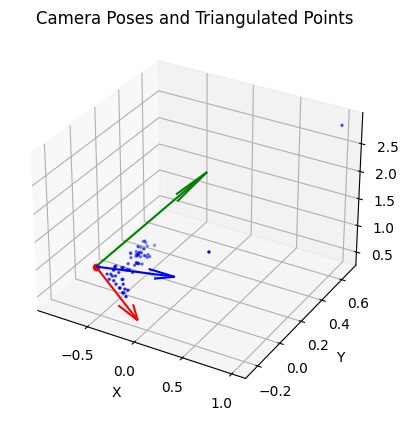

In [ ]:
def plot_camera_poses_and_points(poses, points_3d):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='blue', s=2)
    for R, t in poses:
        camera_center = -R.T @ t
        ax.scatter(camera_center[0], camera_center[1], camera_center[2], c='red', marker='o')
        for axis, color in zip(np.eye(3), ['r', 'g', 'b']):
            direction = R.T @ axis
            ax.quiver(camera_center[0], camera_center[1], camera_center[2],
                      direction[0], direction[1], direction[2], color=color)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Camera Poses and Triangulated Points')
    plt.tight_layout()
    plt.show()

plot_camera_poses_and_points([correct_pose], points_3d)

### 10. Error Analysis for Two-view Geometry
   **Implement a function to calculate and plot the reprojection error for triangulated 3D points.**  
   Measure the difference between original 2D points and the reprojected points on both images.

   Theory : How does this error analysis help in refining the camera pose selection?

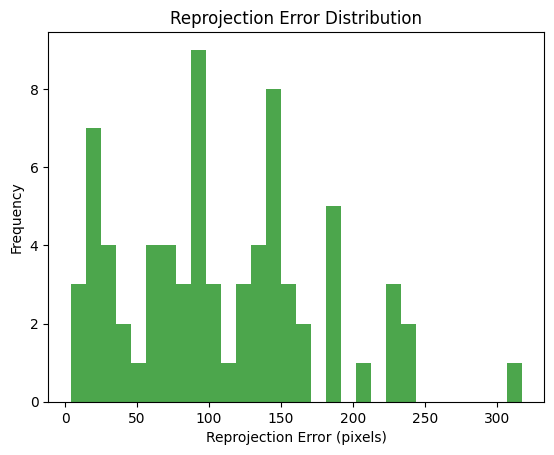

Mean Reprojection Error: 54.0229216716489


In [171]:
def calculate_reprojection_error(P, points_3d, original_points):
    points_3d_h = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
    projected_points_h = (P @ points_3d_h.T).T
    projected_points = projected_points_h[:, :2] / projected_points_h[:, 2][:, np.newaxis]
    errors = np.linalg.norm(projected_points - original_points, axis=1)
    mean_error = np.mean(errors)
    return errors, mean_error

def plot_reprojection_error(errors):
    plt.figure()
    plt.hist(errors, bins=30, alpha=0.7, color='green')
    plt.xlabel('Reprojection Error (pixels)')
    plt.ylabel('Frequency')
    plt.title('Reprojection Error Distribution')
    plt.show()

errors1, mean_error1 = calculate_reprojection_error(P1, points_3d, points1)
errors2, mean_error2 = calculate_reprojection_error(P2, points_3d, points2)
plot_reprojection_error(errors1 + errors2)
print(f"Mean Reprojection Error: {(mean_error1 + mean_error2) / 2}")

**Answer:**

- It tells us how accurately the 3D points, when projected back onto the image planes, match the original 2D points. It can thus be used to evaluate the quality of triangulation and estimation of camera pose.

- Lower reprojection errors typically indicate a better estimation of the camera parameters and 3D reconstruction.

- Statistical observations can indicate several underlying flaws. For example, the presence of many outliers can indicate poor thresholding in earlier stages. 